# Setup Bagging 

## 1. Bagging with Decision Trees

### Import packages

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import mode
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from plot_utils import plot_2d_data, plot_2d_classifier
import matplotlib.pyplot as plt

### Training

In [2]:
rng = np.random.RandomState(seed=4190)
def bagging_fit(X, y, n_estimators, max_depth=5, max_samples=200):
    n_examples = len(y)   
    estimators = [DecisionTreeClassifier(max_depth=max_depth)  
                  for _ in range(n_estimators)]  
    
    for tree in estimators:
        bag = np.random.choice(n_examples, max_samples, replace=True)  
        tree.fit(X[bag, :], y[bag])  
        
    return estimators

### Prediction

In [3]:
def bagging_predict(X, estimators):
    all_predictions = np.array([tree.predict(X) for tree in estimators])  
    ypred, _ = mode(all_predictions, axis=0, keepdims=False)  
    return np.squeeze(ypred)

In [4]:
X, y = make_moons(n_samples=300, noise=.25, random_state=rng)
Xtrn, Xtst, ytrn, ytst = train_test_split(X, y, test_size=0.33, random_state=rng)
bag_ens = bagging_fit(Xtrn, ytrn, n_estimators=500,
                      max_depth=12, max_samples=300)
ypred = bagging_predict(Xtst, bag_ens)

print(accuracy_score(ytst, ypred))

0.898989898989899


In [5]:
ensembleAcc = accuracy_score(ytst, ypred)
print('Bagging: Holdout accuracy = {0:4.2f}%.'.format(ensembleAcc * 100))

tree = DecisionTreeClassifier(max_depth=12)
ypred_single = tree.fit(Xtrn, ytrn).predict(Xtst)
treeAcc = accuracy_score(ytst, ypred_single)
print('Single Decision Tree: Holdout test accuracy = {0:4.2f}%.'.format(treeAcc * 100))

Bagging: Holdout accuracy = 89.90%.
Single Decision Tree: Holdout test accuracy = 84.85%.


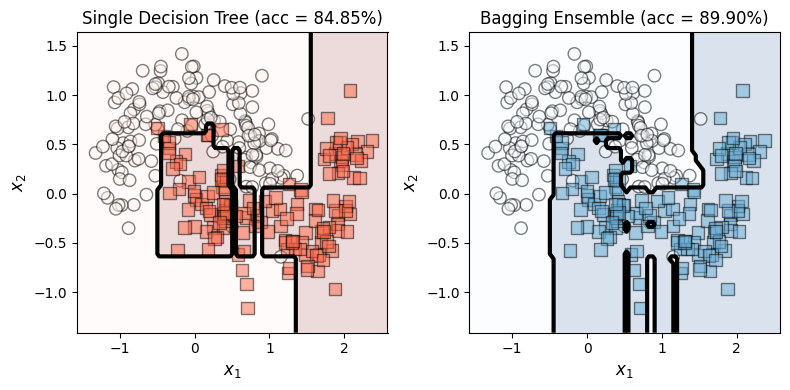

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

title = 'Single Decision Tree (acc = {0:4.2f}%)'.format(treeAcc*100)
plot_2d_classifier(ax[0], X, y, colormap='Reds', alpha=0.15, s=80,
                   predict_function=tree.predict,
                   xlabel='$x_1$', ylabel='$x_2$', title=title)

title = 'Bagging Ensemble (acc = {0:4.2f}%)'.format(ensembleAcc*100)
plot_2d_classifier(ax[1], X, y, colormap='Blues', alpha=0.15, s=80,
                   predict_function=bagging_predict, predict_args=(bag_ens),
                   xlabel='$x_1$', ylabel='$x_2$', title=title)

fig.tight_layout()

## 2.Bagging with scikit-learn

### Import packages

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

### Setup

In [8]:
base_estimator = DecisionTreeClassifier(max_depth=10)
bag_ens = BaggingClassifier(base_estimator=base_estimator, n_estimators=500, 
                            max_samples=100, oob_score=True, random_state=rng)
bag_ens.fit(Xtrn, ytrn)
ypred = bag_ens.predict(Xtst)

/home/ai/anaconda3/envs/ensemble_learning/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [10]:
bag_ens.oob_score_

0.9402985074626866

In [11]:
accuracy_score(ytst, ypred)

0.9292929292929293

### Visualize the smoothing behavior of the BaggingClassifier by comparing its decision boundary to its component base DecisionTreeClassifiers.

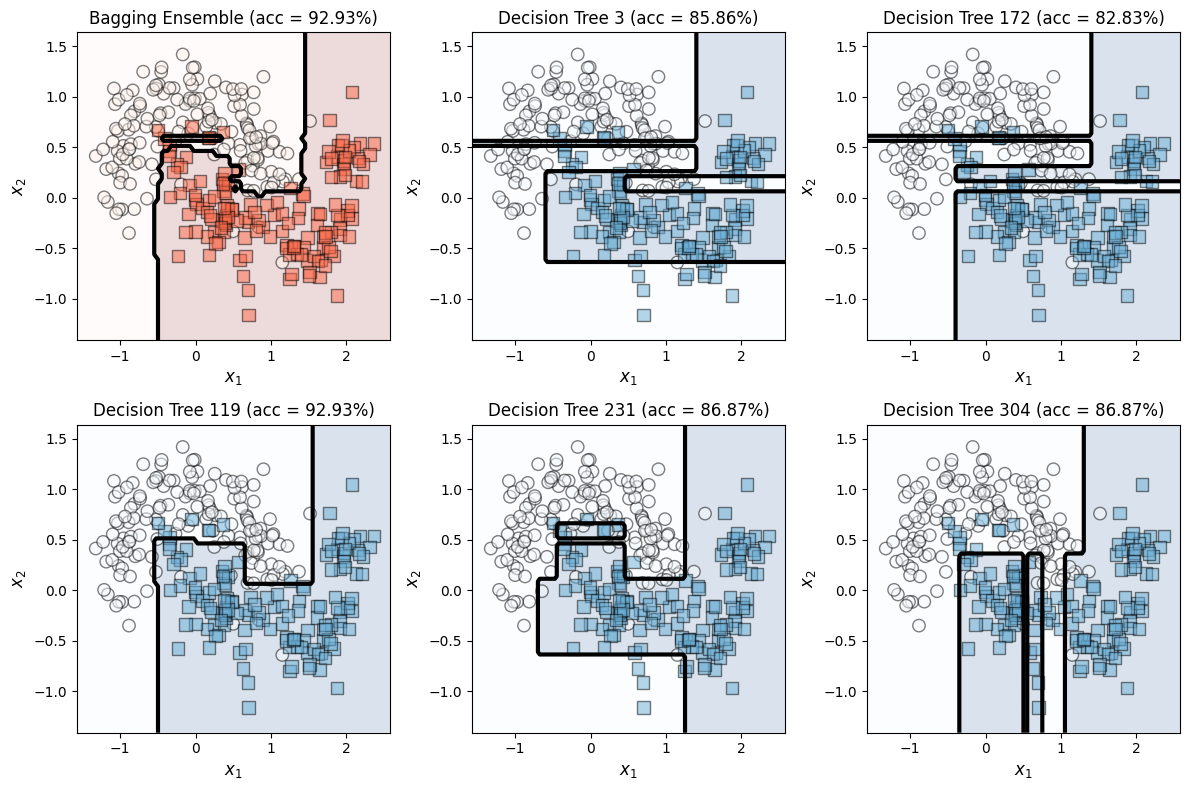

In [12]:
%matplotlib inline

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
trees_to_plot = np.random.choice(500, 5, replace=True)

title = 'Bagging Ensemble (acc = {0:4.2f}%)'.format(accuracy_score(ytst, ypred)*100)
plot_2d_classifier(ax[0, 0], X, y, colormap='Reds', alpha=0.15, s=80,
                   predict_function=bag_ens.predict, 
                   xlabel='$x_1$', ylabel='$x_2$', title=title)

for i in range(5):
    r, c = np.divmod(i + 1, 3)  # Get the row and column index of the subplot
    j = trees_to_plot[i]
    
    tst_acc_clf = accuracy_score(ytst, bag_ens[j].predict(Xtst))
    
    bag = bag_ens.estimators_samples_[j] 
    X_bag = X[bag, :]
    y_bag = y[bag]
    
    title = 'Decision Tree {1} (acc = {0:4.2f}%)'.format(tst_acc_clf*100, j+1)
    plot_2d_classifier(ax[r, c], X, y, colormap='Blues', alpha=0.15, s=80,
                       predict_function=bag_ens[j].predict, 
                       xlabel='$x_1$', ylabel='$x_2$', title=title)

fig.tight_layout()